<a href="https://colab.research.google.com/github/arriagajorge/Brow-Finance/blob/main/GBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# -*- coding: utf-8 -*-
"""Análisis y Simulación de Acciones del S&P 500 por Precio Esperado.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1_v_m5P5e7s_g_z_qC9bC3n9J8XwYtL4K

## 1. Instalación de Librerías

Primero, nos aseguramos de tener las librerías necesarias.
"""

!pip install yfinance pandas numpy scipy -q

"""---
## 2. Obtención de Tickers del S&P 500

Usamos `pandas` para obtener la lista de empresas del S&P 500 desde Wikipedia.
"""

import pandas as pd

try:
    # Obtenemos la tabla de Wikipedia con los tickers del S&P 500
    tabla = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    sp500_tickers = tabla[0]['Symbol'].tolist()
    print(f"✅ Se obtuvieron {len(sp500_tickers)} tickers del S&P 500.")
except Exception as e:
    print(f"⚠️ No se pudo obtener la lista de tickers: {e}")
    # Lista de respaldo en caso de fallo
    sp500_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'TSLA', 'JPM', 'JNJ', 'V', 'PG']

"""---
## 3. Descarga de Datos y Prueba de Normalidad

Descargamos los datos del último año, calculamos los rendimientos logarítmicos y aplicamos la prueba de normalidad de Shapiro-Wilk para filtrar las acciones.
"""

import yfinance as yf
import numpy as np
from datetime import datetime, timedelta
from scipy.stats import shapiro

# Definimos el período de tiempo (1 año)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Lista para guardar los tickers que pasan la prueba de normalidad
normal_stocks_tickers = []
stock_data = {}

print("Descargando datos y filtrando por distribución normal...")
for ticker in sp500_tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        if not data.empty and len(data) > 30: # Aseguramos suficientes datos
            # Calculamos los rendimientos logarítmicos
            data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
            data.dropna(inplace=True)

            # Prueba de normalidad de Shapiro-Wilk
            if len(data['Log_Returns']) > 3:
                stat, p_value = shapiro(data['Log_Returns'])
                # Si el p-valor > 0.05, no rechazamos la hipótesis de normalidad
                if p_value > 0.05:
                    normal_stocks_tickers.append(ticker)
                    stock_data[ticker] = data
    except Exception as e:
        # Ignoramos los tickers con problemas
        pass

print(f"✅ Se encontraron {len(normal_stocks_tickers)} acciones cuyos rendimientos siguen una distribución normal.")


✅ Se obtuvieron 503 tickers del S&P 500.
Descargando datos y filtrando por distribución normal...


/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)
/tmp/ipython-input-7-833310121.py:5

✅ Se encontraron 6 acciones cuyos rendimientos siguen una distribución normal.


/tmp/ipython-input-7-833310121.py:56: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, progress=False)


In [8]:
"""---
## 4. Simulación y Cálculo del Precio Esperado

Ahora, para cada acción que pasó el filtro, simulamos su precio futuro y calculamos el valor esperado.

El **Movimiento Browniano Geométrico (MBG)** se modela con la ecuación:

$$ S_t = S_0 \exp\left( (\mu - \frac{1}{2}\sigma^2)t + \sigma W_t \right) $$

Donde:
- $S_t$ es el precio futuro.
- $S_0$ es el precio inicial.
- $\mu$ es la media de los rendimientos (deriva).
- $\sigma$ es la desviación estándar de los rendimientos (volatilidad).
- $W_t$ es un proceso de Wiener (movimiento browniano).
- $t$ es el tiempo.
"""

# Parámetros de la simulación
num_simulations = 10000
time_horizon = 21  # Días de trading en un mes

expected_prices = {}

print("Ejecutando simulaciones de Montecarlo...")

for ticker in normal_stocks_tickers:
    data = stock_data[ticker]

    # Verificación de seguridad: nos aseguramos de que hay datos antes de proceder
    if data.empty:
        continue # Si está vacío, saltamos al siguiente ticker

    # Calculamos la deriva (mu) y la volatilidad (sigma)
    mu = data['Log_Returns'].mean()
    sigma = data['Log_Returns'].std()

    # Forma correcta de obtener el último precio
    last_price = data['Close'].iloc[-1]

    # ... el resto del código de la simulación sigue igual ...
    final_prices = np.zeros(num_simulations)

    for i in range(num_simulations):
        daily_returns = np.exp(mu - 0.5 * sigma**2 + sigma * np.random.normal(0, 1, time_horizon))
        final_price = last_price * np.prod(daily_returns)
        final_prices[i] = final_price

    expected_prices[ticker] = np.mean(final_prices)

# Ordenamos las acciones por su precio esperado en orden descendente
sorted_stocks_by_expected_price = sorted(expected_prices.items(), key=lambda item: item[1], reverse=True)


/tmp/ipython-input-8-2642609726.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  final_prices[i] = final_price


Ejecutando simulaciones de Montecarlo...



🏆 TOP 5 ACCIONES CON EL PRECIO ESPERADO MÁS ALTO EN 1 MES 🏆

--- NVR ---
Cambio Esperado: -1.24%



/tmp/ipython-input-17-3315306821.py:41: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  price_path[0] = last_price


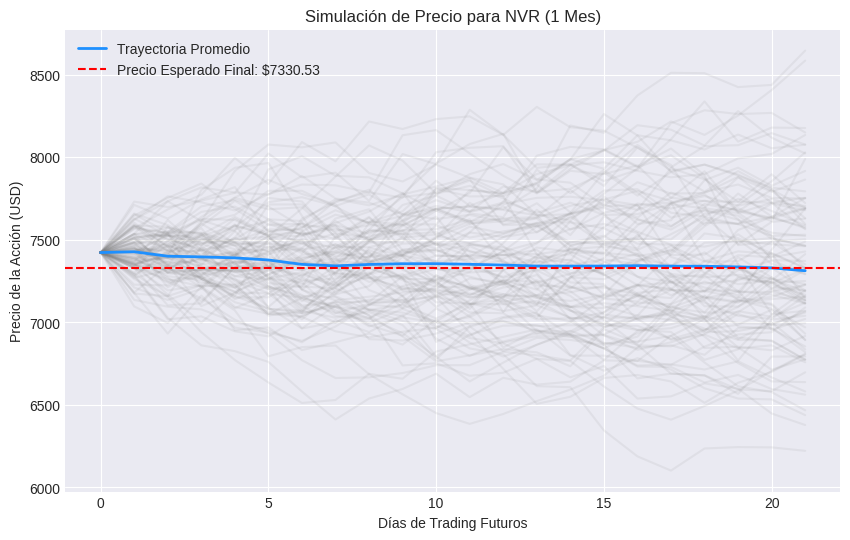

--- DHI ---
Cambio Esperado: -2.31%



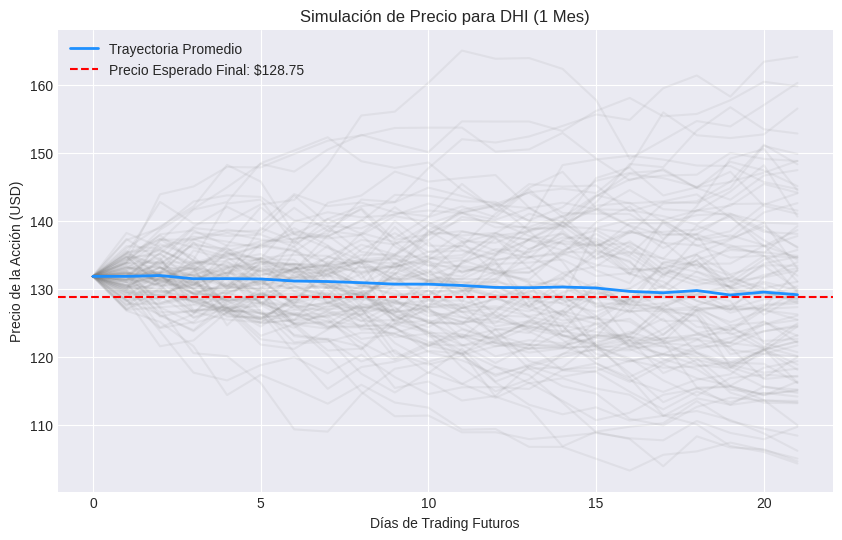

--- WEC ---
Cambio Esperado: +2.49%



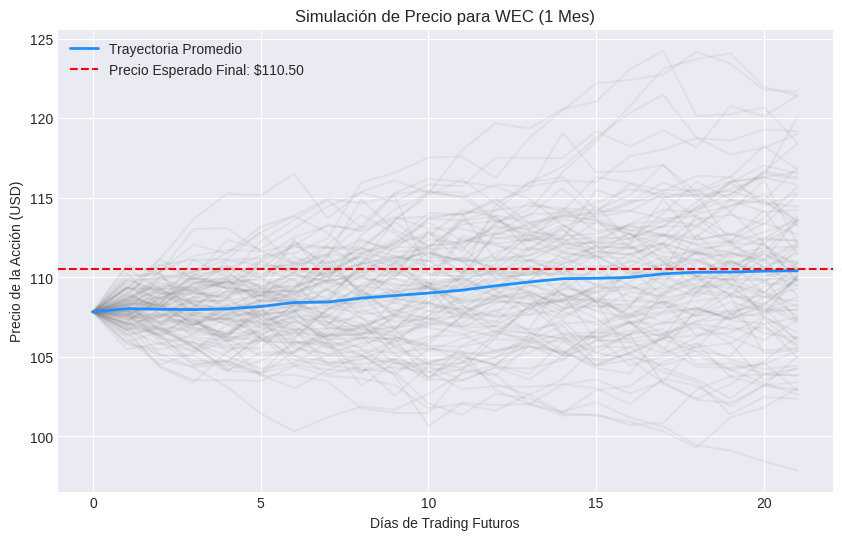

--- LEN ---
Cambio Esperado: -3.46%



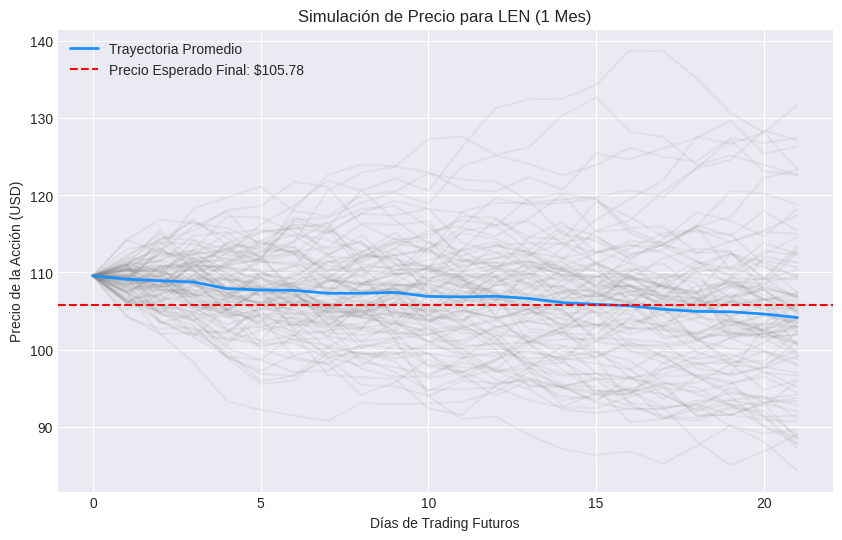

--- ED ---
Cambio Esperado: +1.31%



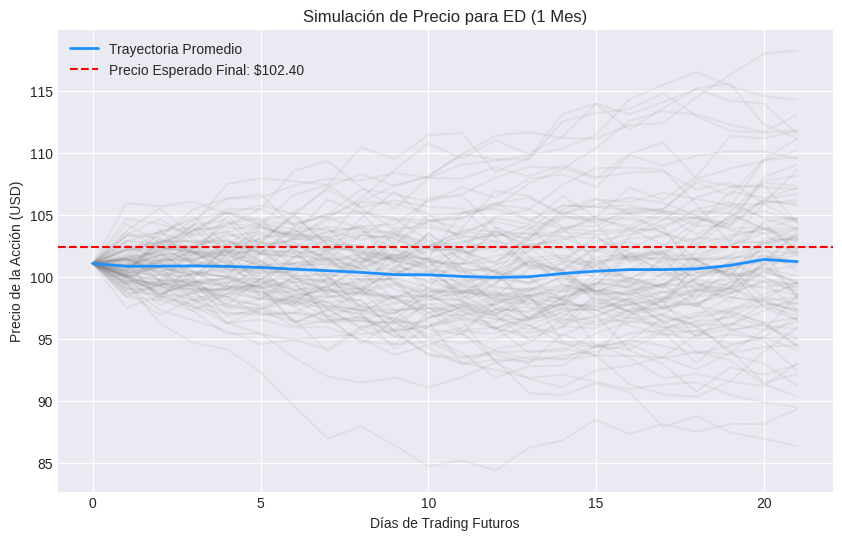

--- PFE ---
Cambio Esperado: -1.17%



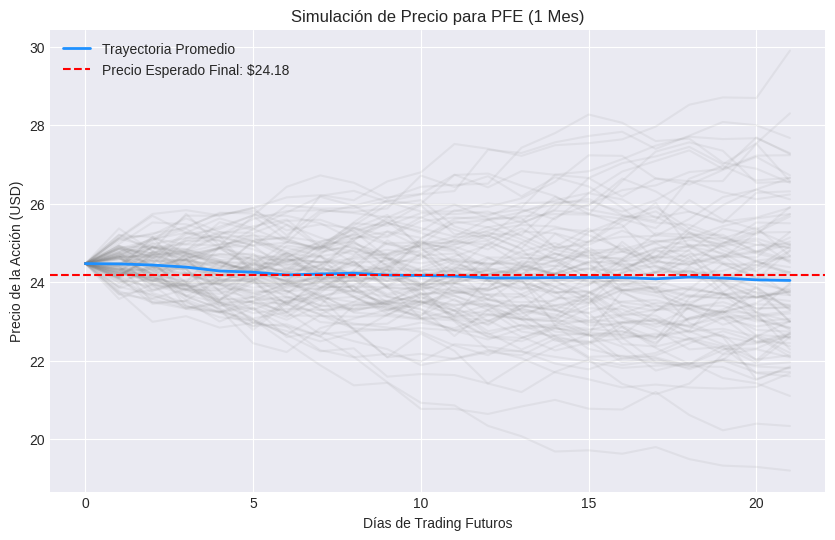

In [17]:
"""---
## 5. Resultados: Top 5 Acciones por Precio Esperado Más Alto

Finalmente, identificamos y visualizamos las 5 acciones con el mayor precio esperado después de un mes.
"""

import matplotlib.pyplot as plt

# Seleccionamos las 5 mejores
top_5_stocks = sorted_stocks_by_expected_price[:6]
top_5_tickers = [stock[0] for stock in top_5_stocks]

print("\n🏆 TOP 5 ACCIONES CON EL PRECIO ESPERADO MÁS ALTO EN 1 MES 🏆\n")

plt.style.use('seaborn-v0_8-darkgrid')

for ticker, expected_price in top_5_stocks:
    data = stock_data[ticker]
    # Verificación de seguridad: nos aseguramos de que hay datos antes de proceder
    if data.empty:
        continue # Si está vacío, saltamos al siguiente ticker

    last_price = data['Close'].iloc[-1]

    print(f"--- {ticker} ---")
    #print(f"Precio de Cierre Actual: ${last_price:,.2f}")
    #print(f"Precio Esperado en 1 Mes: ${expected_price:,.2f}")
    percentage_change = ((expected_price - last_price) / last_price) * 100
    print(f"Cambio Esperado: {percentage_change.iloc[0]:+.2f}%\n")

    # Para visualizar, corremos una simulación más pequeña solo para el gráfico
    plt.figure(figsize=(10, 6))
    simulation_matrix = np.zeros((time_horizon + 1, 100)) # Matriz para 100 trayectorias
    simulation_matrix[0, :] = last_price

    mu = data['Log_Returns'].mean()
    sigma = data['Log_Returns'].std()

    for i in range(100):
        price_path = np.zeros(time_horizon + 1)
        price_path[0] = last_price
        for t in range(1, time_horizon + 1):
            daily_return = np.exp(mu - 0.5 * sigma**2 + sigma * np.random.normal(0, 1))
            price_path[t] = price_path[t-1] * daily_return
        simulation_matrix[:, i] = price_path

    plt.plot(simulation_matrix, color='gray', alpha=0.1)
    plt.plot(simulation_matrix.mean(axis=1), color='dodgerblue', linewidth=2, label='Trayectoria Promedio')
    plt.axhline(y=expected_price, color='red', linestyle='--', label=f'Precio Esperado Final: ${expected_price:.2f}')
    plt.title(f'Simulación de Precio para {ticker} (1 Mes)')
    plt.xlabel('Días de Trading Futuros')
    plt.ylabel('Precio de la Acción (USD)')
    plt.legend()
    plt.show()